# 1D surface wave dispersion inversion

In this tutorial, we use GeoPVI package to perform surface wave inversion to build a 1D layered Earth model using dispersion curves. The forward problem is solved using the **pysurf96** package ([https://github.com/miili/pysurf96](https://github.com/miili/pysurf96)), which is a slim Python wrapper to call the program **surf96** provided by _Computer programs in seismology_. Therefore, to run this tutorial you need to install **pysurf96** first.

## Import libraries

In [1]:
import numpy as np
import torch
import geopvi
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

In [2]:
torch.set_default_dtype(torch.float64)

## Set you own GeoPVI path

In [3]:
geopvi_path = '/home/xzhao34/study/00_GeoPVI/'

## Generate synthetic test

We first create a dispersion curve used as the observed data in this synthetic test.

In [4]:
from pysurf96 import surf96

In [5]:
thk = np.full((10),fill_value=0.1)
thk[-1] = 0; # set the thickness of last layer to be 0 to represent half space
vs = np.zeros_like(thk)
vs = np.array([0.4,0.5,0.6,0.6,0.6,0.8,0.85,0.9,1.0,1.0])

# vp and density are calculate from shear velocity using experience relationships
vp = 1.16*vs + 1.36
rho = 1.74*vp**0.25
if(vs[0]<1e-4):
    vp[0] = 1.5
    rho[0] = 1.0

In [6]:
periods = np.linspace(0.7,2.0,14) # set period range
# It is better to calculate phase velocity on evenly-spaced periods than evenly-spaced frequencies
freqs = 1./periods;

# using disp to calculate phase velocity dispersion curve
# phase = disp(thk,vp,vs,rho,freqs,modetype=1,phasetype=0,dc=5e-4)
phase = surf96(thk, vp, vs, rho, periods, wave = 'rayleigh', mode = 1, velocity = 'phase')
print(phase)

[0.45016026 0.47009307 0.48837453 0.50460595 0.51927632 0.53320795
 0.54718101 0.56182909 0.57764709 0.595007   0.61415255 0.63515556
 0.65784937 0.68175888]


/scratch/xzhao34/.conda/envs/pywork/lib/python3.9/site-packages/pysurf96/wrapper.py:97: RuntimeWarning: overflow encountered in cast
  error = surfdisp96(


In [7]:
# Add random noise to dispersion data
d_obs = phase + np.random.normal(0, 1, len(phase)) * phase * 0.01

In [8]:
zd = np.cumsum(thk)-0.1
zd[-1]=0.9

In [9]:
np.abs(d_obs - phase).mean()

0.004023814398397488

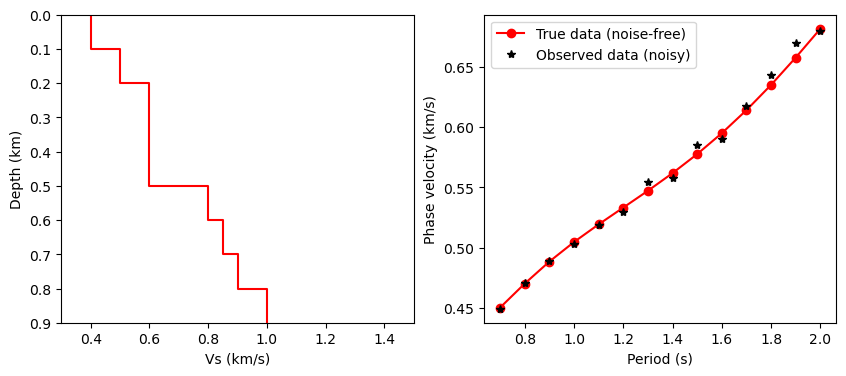

In [10]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.step(vs,zd,'r-',label='True')
plt.gca().invert_yaxis()
plt.xlabel('Vs (km/s)')
plt.ylabel('Depth (km)')
plt.xlim(0.3,1.5)
plt.ylim(0.9, 0.)

plt.subplot(122)
plt.plot(periods, phase, 'ro-', label='True data (noise-free)')
plt.plot(periods, d_obs, 'k*', label='Observed data (noisy)')
plt.xlabel('Period (s)'); plt.ylabel('Phase velocity (km/s)')
# plt.tight_layout()
plt.legend()

## Perform inversion

#### Define a Uniform prior distribution for velocity values in each layer

In [11]:
from geopvi.prior import Uniform

In [12]:
lower = np.array([0.33, 0.43, 0.48, 0.51, 0.55, 0.6, 0.58, 0.56, 0.56, 0.6])
upper = np.array([0.63, 0.79, 0.88, 0.95, 1.05, 1.2, 1.28, 1.36, 1.36, 1.4])

In [13]:
prior = Uniform(lower = lower, upper = upper)

#### Define function to calculate log posterior probability values

In [14]:
def forward_sw(vs, periods, thick, relative_step = 0.01, wave = 'rayleigh', mode = 1, velocity = 'phase', requires_grad = True):
    vp = 1.16 * vs + 1.36
    rho = 1.74 * vp ** 0.25
    d_syn = surf96(thick, vp, vs, rho, periods, wave = wave, mode = mode, velocity = velocity)

    gradient = np.zeros((len(periods), len(vs)))
    if requires_grad:
        for i in range(len(vs)):
            vs_tmp = vs.copy()
            step = relative_step * vs[i]
            vs_tmp[i] += step
            vp_tmp = 1.16 * vs_tmp + 1.36
            rho_tmp = 1.74 * vp_tmp ** 0.25
            d_tmp = surf96(thick, vp_tmp, vs_tmp, rho_tmp, periods, wave = wave, mode = mode, velocity = velocity)
            derivative = (d_tmp - d_syn) / abs(step)
            gradient[:, i] = derivative

    return d_syn, gradient

In [446]:
data, grad = forward_sw(vs, periods, thk, relative_step = 0.00001)

In [16]:
from torch.multiprocessing import Pool
from torch.autograd import Function

In [17]:
class ForwardModel(Function):
    @staticmethod
    def forward(ctx, input, func):
        output, grad = func(input)
        ctx.save_for_backward(input, torch.tensor(grad))
        return torch.tensor(output)

    @staticmethod
    def backward(ctx, grad_output):
        input, grad = ctx.saved_tensors
        grad_input = (grad_output[...,None] * grad).sum(axis = -2)
        return grad_input, None

In [715]:
class Posterior():
    def __init__(self, data, thick, periods, sigma = 0.003, log_prior = None, wave = 'rayleigh', mode = 1, velocity = 'phase'):
        self.log_prior = log_prior
        self.data = data
        self.periods = periods
        self.thick = thick
        self.sigma = sigma
        self.wave = wave
        self.mode = mode
        self.velocity = velocity

    def solver(self, x):
        '''
        Calculate modelled data and data-model gradient by calling the external forward function (surf96)
        '''
        m, n = x.shape
        phase = np.zeros([m, self.data.shape[0]])
        gradient = np.zeros([m, self.data.shape[0], n])
        for i in range(m):
            vs = x.data.numpy()[i].squeeze()
            phase[i], gradient[i] = forward_sw(vs, self.periods, self.thick, relative_step = 0.005, wave = self.wave, mode = self.mode, velocity = self.velocity)
        return phase, gradient
    
    def log_prob(self, x):
        """
        calculate log posterior and its gradient directly from model x
        This version considers the transform from real to constrained space
        thus returns log_loke + log_det
        """
        d_syn = ForwardModel.apply(x, self.solver)
        log_like = - 0.5 * torch.sum(((torch.from_numpy(self.data) - d_syn)/self.sigma) ** 2, axis = -1)
        log_prior = self.log_prior(x)
        # print(log_prior)
        # # set a prior information: the top layer has minimum shear-velocity
        # # This ensures the computed phase velocities are phase velocities of Rayleigh or Love waves  
        # for i in range(x.shape[0]):
        #     if x[i, 1:].min() < x[i,0]:
        #         log_prior[i] -= 10.

        logp = log_like + log_prior
        return logp

In [716]:
posterior = Posterior(d_obs, thk, periods, sigma = 0.004, log_prior = prior.log_prob, wave = 'rayleigh', mode = 1, velocity = 'phase')

In [461]:
d_obs

array([0.44918054, 0.4705576 , 0.48849754, 0.50280134, 0.51873306,
       0.52968277, 0.55429296, 0.55810368, 0.585227  , 0.59054138,
       0.61767166, 0.64347242, 0.66977666, 0.67951194])

## Define variational model

### ADVI

In [994]:
from geopvi.nfvi.flows import Real2Constr, Linear

flows_mf_advi = [Linear(dim = thk.size, kernel = 'fullrank'), Real2Constr(dim = thk.size, lower = lower, upper = upper)]

In [995]:
from geopvi.nfvi.models import FlowsBasedDistribution

variational_mf_advi = FlowsBasedDistribution(flows_mf_advi, base = 'Normal')

In [996]:
from geopvi.nfvi.models import VariationalInversion

mf_advi = VariationalInversion(variationalDistribution = variational_mf_advi, log_posterior = posterior.log_prob)

In [997]:
loss_mf_advi = mf_advi.update(optimizer = 'torch.optim.Adam', lr = 0.001, n_iter = 10000, nsample = 5, n_out = 5, verbose = True)

----------------------------------------

Iteration:     0,	Loss:   10931.91
The elapsed time is: 0.03 s
Iteration:  2000,	Loss:     199.17
The elapsed time is: 25.02 s
Iteration:  4000,	Loss:     103.66
The elapsed time is: 49.83 s
Iteration:  6000,	Loss:      36.34
The elapsed time is: 74.69 s
Iteration:  8000,	Loss:      27.55
The elapsed time is: 99.60 s
Iteration: 10000,	Loss:      26.63
The elapsed time is: 124.59 s
----------------------------------------

Finish training!


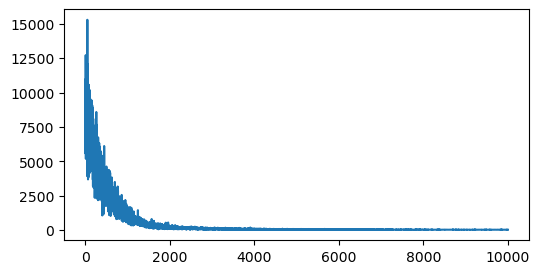

In [999]:
plt.figure(figsize = (6, 3))
plt.plot(loss_mf_advi)

### Normalising flows

In [833]:
from geopvi.nfvi.flows import NSF_CL, Permute, Constr2Real, RealNVP, SIAF, NSF_SAR

In [955]:
flows_nf = []

for _ in range(6):
    # flows_nf += [NSF_CL(dim = thk.size, K = 8, B = 3, hidden_dim = [12, 12]), Permute(dim = thk.size)]
    flows_nf += [RealNVP(dim = thk.size,hidden_dim = [12, 12]), Permute(dim = thk.size)]
    # flows_nf += [SIAF(dim = thk.size, hidden_dim = [12, 12]), Permute(dim = thk.size)]
    # flows_nf += [NSF_SAR(dim = thk.size, K = 8, B = 3, hidden_dim = [12, 12]), Permute(dim = thk.size)]
flows_nf += [Real2Constr(dim = thk.size, lower = lower, upper = upper)]
# flows_nf.insert(0, Constr2Real(dim = thk.size, lower = 0, upper = 1))

In [956]:
variational_nf = FlowsBasedDistribution(flows_nf, base = 'Normal')

In [957]:
sum(p.numel() for p in variational_nf.parameters())

7032

In [958]:
nf = VariationalInversion(variationalDistribution = variational_nf, log_posterior = posterior.log_prob)
loss_nf = nf.update(optimizer = 'torch.optim.Adam', lr = 0.001, n_iter = 10000, nsample = 5, n_out = 5, verbose = True)

----------------------------------------

Iteration:     0,	Loss:   10399.18
The elapsed time is: 0.04 s
Iteration:  2000,	Loss:      28.25
The elapsed time is: 34.54 s
Iteration:  4000,	Loss:      25.92
The elapsed time is: 68.75 s
Iteration:  6000,	Loss:      24.80
The elapsed time is: 102.91 s
Iteration:  8000,	Loss:      25.85
The elapsed time is: 137.04 s
Iteration: 10000,	Loss:      25.08
The elapsed time is: 171.14 s
----------------------------------------

Finish training!


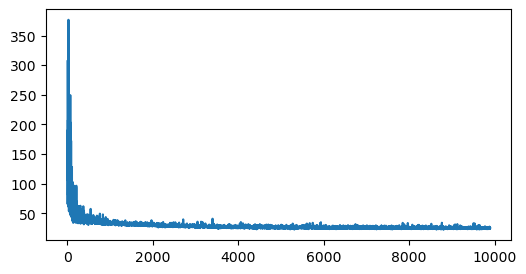

In [959]:
plt.figure(figsize = (6, 3))
plt.plot(loss_nf[100:])

### McMC

In [399]:
def real_2_const(input, lower, upper):
    log_det = (np.log(upper - lower) - input - 2 * np.log(1 + np.exp(-input))).sum(axis = -1)
    output = lower + (upper - lower) / (1 + np.exp(-input))
    return output, log_det

In [256]:
mcmc_path = '/exports/csce/datastore/geos/users/xzhao34/study/05_dispersion_inversion/Zhao_tomo_mcmc/output/'

In [790]:
tmp = np.loadtxt(mcmc_path + 'mcmc_from_log_sample_500000draws_6chains.txt')
tmp, _ = real_2_const(tmp, lower, upper)

In [298]:
data_mcmc = np.loadtxt(mcmc_path + 'mcmc_from_log_data_500000draws_1chains.txt')

In [449]:
misfit = ((data_mcmc - d_obs) ** 2).sum(axis = 1)

In [791]:
samples_mcmc = tmp.reshape(6, -1, thk.size)[:,300000::100].reshape(-1, thk.size)
mean_mcmc = samples_mcmc.mean(axis = 0)

In [792]:
samples_mcmc.shape

(12000, 10)

## Display inversion results

In [1010]:
samples_advi = variational_mf_advi.sample(5000)
samples_nf = variational_nf.sample(5000)
# samples = bvi.sample(5000)
mean_advi = np.mean(samples_advi,axis=0)
mean_nf = np.mean(samples_nf,axis=0)

In [1011]:
data_syn = np.zeros([samples.shape[0], periods.size])

for i in range(data_syn.shape[0]):
    data_syn[i], _ = forward_sw(samples_nf[i], periods, thk, requires_grad = False)

Text(0.5, 1.0, 'ADVI')

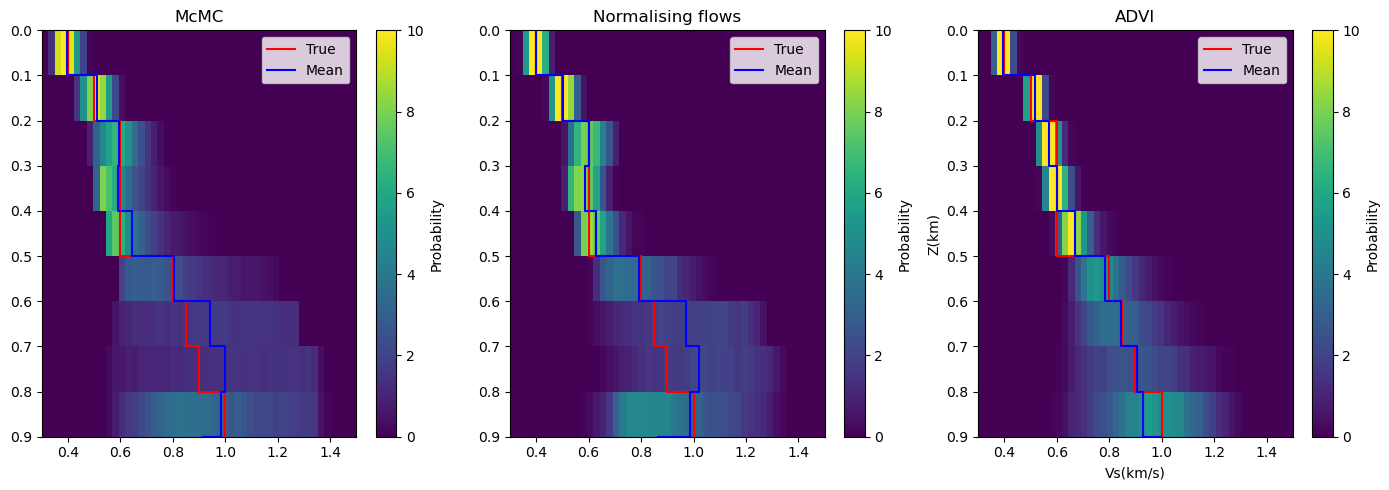

In [1012]:
fig, ax = plt.subplots(ncols=3,nrows=1,figsize=(14,5))

zd = np.cumsum(thk)-0.1; zd[-1]=0.9
z=zd
zd = np.tile(zd,samples_mcmc.shape[0])
xd = samples_mcmc.flatten()
x_edges = np.linspace(0.3,1.5,50)
y_edges = z
im =ax[0].hist2d(xd,zd,bins=[x_edges,y_edges],density=True,vmin=0,vmax=10)
ax[0].step(vs,z,'r-',label='True')
ax[0].step(mean_mcmc,z,'b-',label='Mean')
ax[0].legend()
ax[0].invert_yaxis()
ax[0].set_xlim(0.3,1.5)
plt.xlabel('Vs(km/s)')
plt.ylabel('Z(km)')
# cax = divider.append_axes("right",size="3%",pad=0.1)
cb = plt.colorbar(im[3], ax = ax[0])
cb.set_label('Probability')
plt.tight_layout()
ax[0].set_title('McMC')

zd = np.cumsum(thk)-0.1; zd[-1]=0.9
z=zd
zd = np.tile(zd,samples_nf.shape[0])
xd = samples_nf.flatten()
x_edges = np.linspace(0.3,1.5,50)
y_edges = z
im =ax[1].hist2d(xd,zd,bins=[x_edges,y_edges],density=True,vmin=0,vmax=10)
ax[1].step(vs,z,'r-',label='True')
ax[1].step(mean_nf,z,'b-',label='Mean')
ax[1].legend()
ax[1].invert_yaxis()
ax[1].set_xlim(0.3,1.5)
plt.xlabel('Vs(km/s)')
plt.ylabel('Z(km)')
# cax = divider.append_axes("right",size="3%",pad=0.1)
cb = plt.colorbar(im[3], ax = ax[1])
cb.set_label('Probability')
plt.tight_layout()
ax[1].set_title('Normalising flows')

zd = np.cumsum(thk)-0.1; zd[-1]=0.9
z=zd
zd = np.tile(zd,samples_advi.shape[0])
xd = samples_advi.flatten()
x_edges = np.linspace(0.3,1.5,50)
y_edges = z
im =ax[2].hist2d(xd,zd,bins=[x_edges,y_edges],density=True,vmin=0,vmax=10)
ax[2].step(vs,z,'r-',label='True')
ax[2].step(mean_advi,z,'b-',label='Mean')
ax[2].legend()
ax[2].invert_yaxis()
ax[2].set_xlim(0.3,1.5)
plt.xlabel('Vs(km/s)')
plt.ylabel('Z(km)')
# cax = divider.append_axes("right",size="3%",pad=0.1)
cb = plt.colorbar(im[3], ax = ax[2])
cb.set_label('Probability')
plt.tight_layout()
ax[2].set_title('ADVI')

/scratch/xzhao34/.conda/envs/pywork/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/scratch/xzhao34/.conda/envs/pywork/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/scratch/xzhao34/.conda/envs/pywork/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/scratch/xzhao34/.conda/envs/pywork/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated

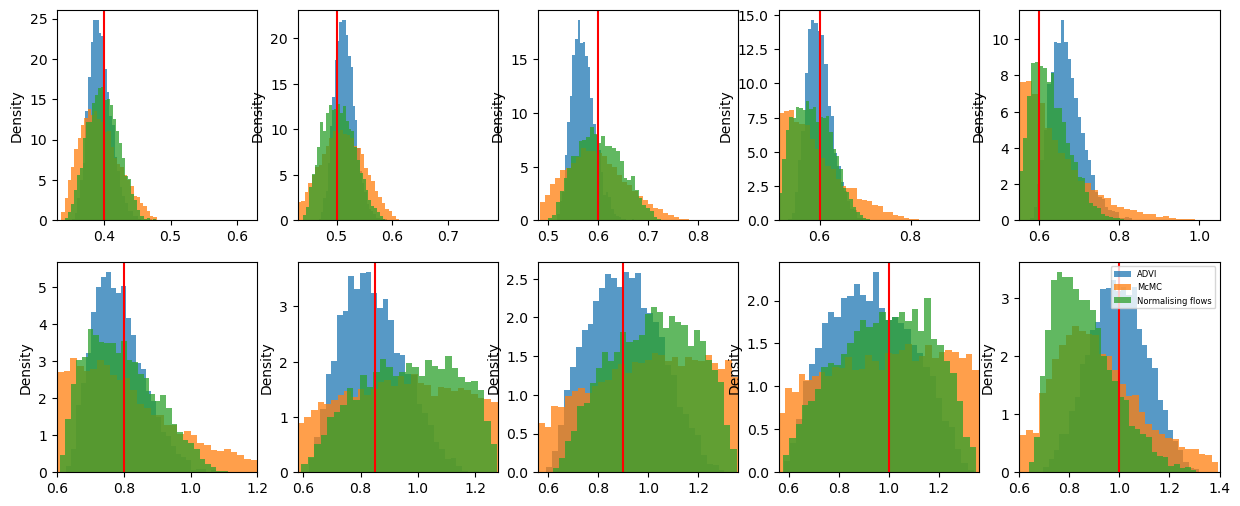

In [1013]:
plt.figure(figsize = (15, 6))

for i in range(10):
    plt.subplot(2,5,i+1)
    sns.histplot(samples_advi[:,i], bins = 30, stat="density", linewidth=0, fill=True, label = 'ADVI')
    sns.histplot(samples_mcmc[:,i], bins = 30, stat="density", linewidth=0, fill=True, label = 'McMC')
    sns.histplot(samples_nf[:,i], bins = 30, stat="density", linewidth=0, fill=True, label = 'Normalising flows')
    
    plt.xlim(lower[i], upper[i])
    plt.axvline(x = vs[i], color = 'red')
    if i == 9:
        plt.legend(fontsize = 6)

Text(0.5, 1.0, 'ADVI')

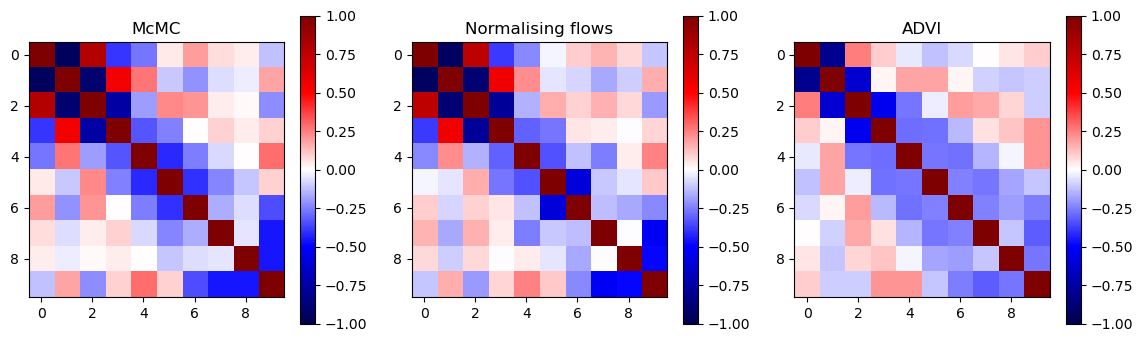

In [1014]:
cor_nf = np.corrcoef(samples_nf, rowvar=False)
cor_mcmc = np.corrcoef(samples_mcmc, rowvar=False)
cor_advi = np.corrcoef(samples_advi, rowvar=False)

plt.figure(figsize = (14, 4))
plt.subplot(131)
plt.imshow(cor_mcmc, clim = [-1, 1], cmap = 'seismic')
plt.colorbar()
plt.title('McMC')

plt.subplot(132)
plt.imshow(cor_nf, clim = [-1, 1], cmap = 'seismic')
plt.colorbar()
plt.title('Normalising flows')

plt.subplot(133)
plt.imshow(cor_advi, clim = [-1, 1], cmap = 'seismic')
plt.colorbar()
plt.title('ADVI')

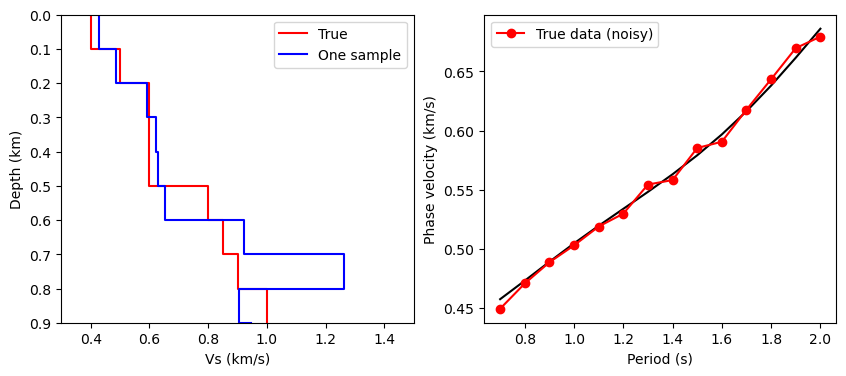

In [1021]:
zd = np.cumsum(thk)-0.1
zd[-1]=0.9

plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.step(vs,zd,'r-',label='True')
# plt.step(samples[0],zd,'b-',label='Inverted')
for i in range(1):
    plt.step(samples_nf[i], zd,'b-',label='One sample')
plt.gca().invert_yaxis()
plt.xlabel('Vs (km/s)')
plt.ylabel('Depth (km)')
plt.xlim(0.3,1.5)
plt.ylim(0.9, 0.)
plt.legend()

plt.subplot(122)
for i in range(1):
    plt.plot(periods, data_syn[i], 'k')
plt.plot(periods, d_obs, 'ro-', label='True data (noisy)')
# plt.plot(periods, d_obs, 'k*', label='Observed data (noisy)')
plt.xlabel('Period (s)'); plt.ylabel('Phase velocity (km/s)')
# plt.tight_layout()
plt.legend()